Przykład użycia autoenkodera wariacyjnego (VAE - variational autoencoder) do geerowania obrazów.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [5]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        
        # Warstwy parametrów latentnych
        self.fc_mu = nn.Linear(128, latent_dim)  # Średnia
        self.fc_logvar = nn.Linear(128, latent_dim)  # Log-wariancja
        
        # Dekoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()  # Sigmoid dla wartości w zakresie [0, 1]
        )
    
    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        # Reparametryzacja: z = mu + epsilon * sigma
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar

In [7]:
# Funkcja straty dla VAE
def loss_function(reconstructed, original, mu, logvar):
    # Rekonstrukcja (binary cross-entropy)
    reconstruction_loss = nn.functional.binary_cross_entropy(reconstructed, original, reduction='sum')
    # Strata Kullback-Leibler
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence

In [9]:
# Przygotowanie danych
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten wejście (28x28 -> 784)
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [11]:
# Inicjalizacja modelu, optymalizatora i parametrów
input_dim = 28 * 28
latent_dim = 10
model = VariationalAutoencoder(input_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Trening VAE
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data, _ in train_loader:  # Ignorujemy etykiety
        inputs = data
        optimizer.zero_grad()
        
        # Forward pass
        reconstructed, mu, logvar = model(inputs)
        loss = loss_function(reconstructed, inputs, mu, logvar)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch [1/10], Loss: 168.6683
Epoch [2/10], Loss: 125.1474
Epoch [3/10], Loss: 117.6062
Epoch [4/10], Loss: 114.3471
Epoch [5/10], Loss: 112.3111
Epoch [6/10], Loss: 110.8981
Epoch [7/10], Loss: 109.8547
Epoch [8/10], Loss: 109.0654
Epoch [9/10], Loss: 108.3662
Epoch [10/10], Loss: 107.6962


In [15]:
# Generowanie nowych danych
model.eval()
with torch.no_grad():
    # Losowe próbki w przestrzeni latentnej
    z = torch.randn(16, latent_dim)
    generated_images = model.decode(z)

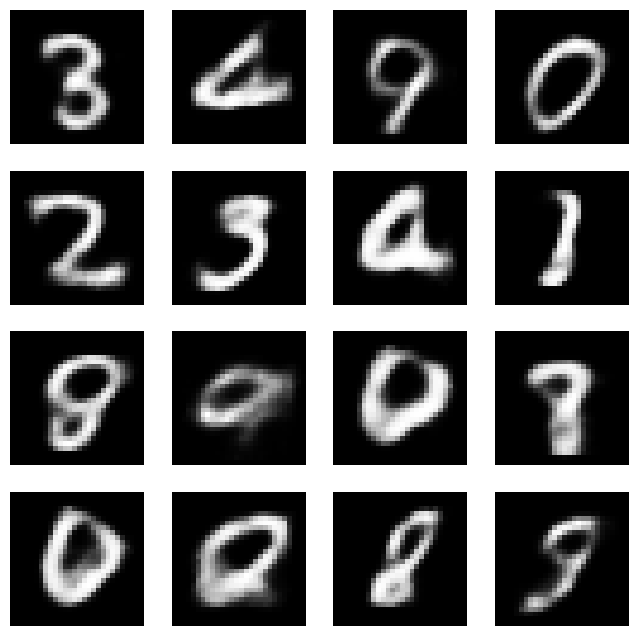

In [17]:
# Wizualizacja wygenerowanych obrazów
plt.figure(figsize=(8, 8))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_images[i].view(28, 28).detach().numpy(), cmap='gray')
    plt.axis('off')
plt.show()